In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

#::: imports
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, FileLink
from scipy.interpolate import UnivariateSpline

#::: local imports
import computer
from mcmc import mcmc_fit
from mcmc_output import mcmc_output

#::: plotting settings
import seaborn as sns
sns.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context(rc={'lines.markeredgewidth': 1})

#::: globals (don't do this at home, kids)
data = {'time':None, 'flux':None, 'flux_err':None}
model = {'time':None, 'flux':None}
params = {'radius_planet':None, 'radius_star':None, 'epoch':None, 'period':None ,'a':None, 'incl':None}
line = None

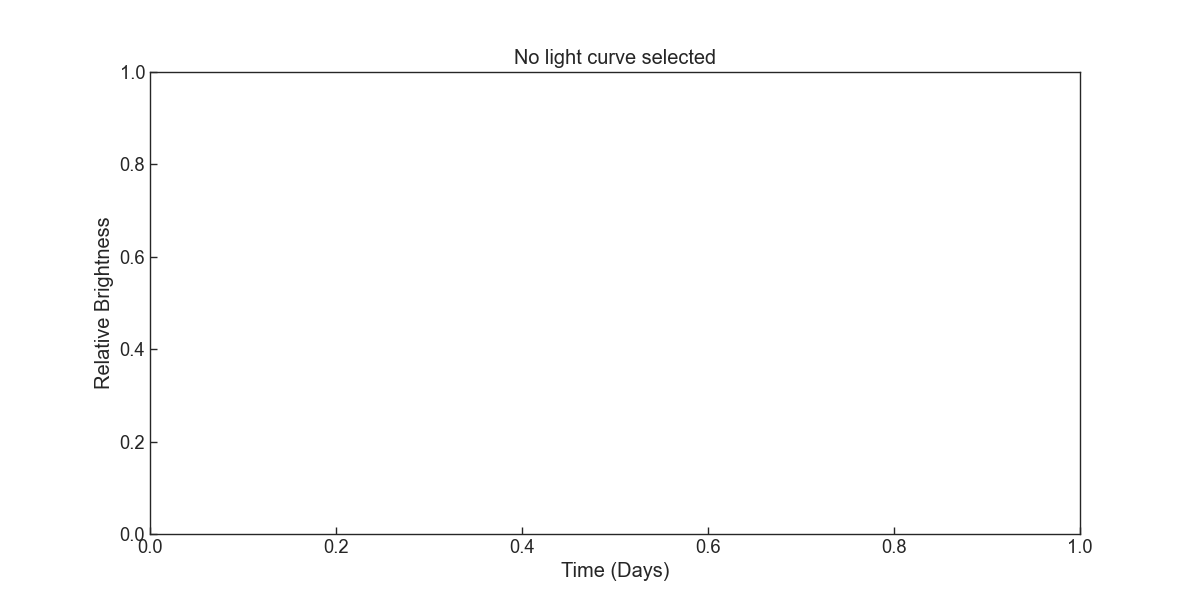

In [2]:
###########################################################################
#::: Define all widgets
###########################################################################
#::: widget dropdown, select which data set you want to load
widget_dropdown_targets = widgets.Dropdown(options = ['Select a target...', 'WASP-189b','TOI-560c','KELT-3b'], description='Target:')

#::: widget sliders, to select the initial guess params
style = {'description_width':'250px'}
layout = {'width':'600px', 'visibility':'hidden'} #hide them to start with
widget_floatslider_radius_planet = widgets.FloatSlider(min=0.1, max=22., value=1., description='Radius of the planet (Earth radii):', style=style, layout=layout)
widget_floatslider_radius_star = widgets.FloatSlider(min=0.1, max=3., value=1., description='Radius of the star (Solar radii):', style=style, layout=layout)
widget_floatslider_epoch = widgets.FloatSlider(min=0., max=1., step=0.01, value=0.3, description='Mid-transit time (days):', style=style, layout=layout)

#::: widget button, to start the MCMC run
layout = {'visibility':'hidden'} #hide the run button to start with
widget_button_run = widgets.Button(description='Investigate', tooltip='Click here to start the algorithm that fits the model to your data.', layout=layout)
widget_output = widgets.Output()

#::: widget images
with open("images/icon1.png", "rb") as file:
    image = file.read()
    im1 = widgets.Image(value=image, format='png', width=150)
with open("images/icon2.png", "rb") as file:
    image = file.read()
    im2 = widgets.Image(value=image, format='png', width=150)
with open("images/icon3.jpg", "rb") as file:
    image = file.read()
    im3 = widgets.Image(value=image, format='jpg', width=150)
    
#::: widget labels
lab1 = widgets.Label(value='Which target should we look at, Detective?')
lab2 = widgets.Label(value='We need good clues to start digging deeper...')
lab3 = widgets.Label(value='I think we are ready to start investigating, Detective!')



###########################################################################
#::: Clean up and set up the new figure
###########################################################################
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.clear()
ax.set(xlabel='Time (Days)', ylabel='Relative Brightness', title='No light curve selected')



###########################################################################
#::: Define all interactive actions
###########################################################################
#::: define the function to execute after the selection
def load_and_plot_data(target_name):
    
    #::: catching the blank state
    if target_name in ['Select a target...','TOI-560c','KELT-3b']: #TODO: Implement TOI-560 c and KELT-3b
        
        #::: handle the figure
        ax.clear()
        ax.set(xlabel='Time (Days)', ylabel='Relative Brightness', title='No light curve selected')
            
        #::: temporarily hide the sliders and button
        im2.layout.visibility = 'hidden'
        lab2.layout.visibility = 'hidden'
        widget_floatslider_radius_planet.layout.visibility = 'hidden'
        widget_floatslider_radius_star.layout.visibility = 'hidden'
        widget_floatslider_epoch.layout.visibility = 'hidden'
        im3.layout.visibility = 'hidden'
        lab3.layout.visibility = 'hidden'
        widget_button_run.layout.visibility = 'hidden'
        
        #::: end here
        return None
    
    else:
        #::: unhide the sliders (but keep the button hidden)
        im2.layout.visibility = 'visible'
        lab2.layout.visibility = 'visible'
        widget_floatslider_radius_planet.layout.visibility = 'visible'
        widget_floatslider_radius_star.layout.visibility = 'visible'
        widget_floatslider_epoch.layout.visibility = 'visible'
    
    #::: globals (don't do this at home, kids)
    global data
    global model
    global params
    global line
    
    #::: load data
    data['time'], data['flux'], data['flux_err'], model['time'] = computer.load_data(target_name)
    
    #::: load frozen params and initial guesses for the sliders
    params['radius_planet'], params['radius_star'], params['epoch'], params['period'], params['a'], params['incl'] = computer.load_params(target_name)
    
    #::: set the sliders
    widget_floatslider_radius_planet.value = params['radius_planet']
    widget_floatslider_radius_star.value = params['radius_star']
    widget_floatslider_epoch.value = params['epoch']
    
    #::: plot the data and an empty model
    ax.set(title='Light curve of '+target_name)
    ax.plot(data['time'], data['flux'], 'b.', label='The evidence')
    line, = ax.plot(model['time'], np.ones_like(model['time']), color='silver', marker=None, linestyle='-', label='Your first clues')
    ax.legend(loc='lower left')
    fig.canvas.draw_idle() #this change was pivotal to make the interactive plot work


    
#::: update the plot with the light curve model
def update_plot(radius_planet, radius_star, epoch):
    
    #::: catching the blank state
    if widget_dropdown_targets.value in ['Select a target...','TOI-560c','KELT-3b']: #TODO: Implement TOI-560 c and KELT-3b
        return None #abort
    
    #::: globals (don't do this at home, kids)
    global data
    global model
    global params
    global line
    
    #::: set params
    params['radius_planet'] = radius_planet
    params['radius_star'] = radius_star
    params['epoch'] = epoch
    
    #::: retrieve the light curve model
    model['flux'] = computer.calc_flux_model(params['radius_planet'], params['radius_star'], params['epoch'], params['period'], params['a'], params['incl'], model['time'])
    
    #::: update the axes (try/except catches some initialisation hickups)
    try:
        line.set_ydata(model['flux'])
    except:
        pass
    fig.canvas.draw_idle() #this change was pivotal to make the interactive plot work
    
    #::: unhide/hide the button, depending on how close the initial guess is to the truth
    if computer.check_initial_guess(widget_dropdown_targets.value, params['radius_planet'], params['radius_star'], params['epoch']):
        im3.layout.visibility = 'visible'
        lab3.layout.visibility = 'visible'
        widget_button_run.layout.visibility = 'visible'
    else:
        im3.layout.visibility = 'hidden'
        lab3.layout.visibility = 'hidden'
        widget_button_run.layout.visibility = 'hidden'
    
    

#::: define the run button
def run(arg):
    
    #::: disable all widgets for luser-proofness
    widget_button_run.disabled = True
    widget_dropdown_targets.disabled = True
    widget_floatslider_radius_planet.disabled = True
    widget_floatslider_radius_star.disabled = True
    widget_floatslider_epoch.disabled = True
    
    #::: change the line color of the initial guess
    #line.set_color('silver') #TODO: somehow this only takes effect after the MCMC run is completed
    
    #::: print statements and other output need an "output widget"
    with widget_output:
         
        #::: start the MCMC run 
        #mcmc_fit(widget_dropdown_targets.value, params)
        posterior_samples, fig1, fig2 = mcmc_output(widget_dropdown_targets.value) #20 samples for plotting
        # fig1.canvas.draw_idle() #this change was pivotal to make the interactive plot work
        # fig2.canvas.draw_idle() #this change was pivotal to make the interactive plot work

        #::: plot the fit
        for i in range(20):

            #::: compute the ellc model (on finer time grid)
            model['flux'] = computer.calc_flux_model(posterior_samples['radius_planet'][i], posterior_samples['radius_star'][i], posterior_samples['epoch'][i], params['period'], params['a'], params['incl'], model['time'])

            #::: compute the the baseline
            y2 = computer.calc_flux_model(posterior_samples['radius_planet'][i], posterior_samples['radius_star'][i], posterior_samples['epoch'][i], params['period'], params['a'], params['incl'], data['time']) #get model on data time grid
            yerr_weights = data['flux_err']/np.nanmean(data['flux_err'])
            weights = 1./yerr_weights
            spl = UnivariateSpline(data['time'], data['flux']-y2, w=weights, s=np.sum(weights)) #train a spline on the data time grid
            baseline = spl(model['time']) #evaluate the spline on the finer time grid

            #::: plot
            ax.plot(model['time'], model['flux']+baseline, 'r-', alpha=0.1)
            
        #::: add a legend
        ax.plot(np.NaN, np.NaN, 'r-', label='Your final investigation results')
        ax.legend(loc='lower left')
            
        #::: show the files
        fname = os.path.join('results',widget_dropdown_targets.value,'mcmc_hist.pdf')
        display(FileLink(fname))

    

#::: link the dropdown menu to the creation of the plot
w1 = widgets.interactive(load_and_plot_data, 
                         target_name=widget_dropdown_targets)



#::: now let's interact with this plot
w2 = widgets.interactive(update_plot,
                         radius_planet = widget_floatslider_radius_planet, 
                         radius_star = widget_floatslider_radius_star, 
                         epoch = widget_floatslider_epoch)

    

#::: execute clicks on the run button
widget_button_run.on_click(run)


        
###########################################################################
#::: Development
###########################################################################
# dev1 = widgets.Button(description='dev')
# def dev():
#     widget_floatslider_radius_planet.value = 18.15
#     widget_floatslider_radius_star.value = 2.36
#     widget_floatslider_epoch.value = 0.36
# dev1.on_click(dev)



###########################################################################
#::: Display everything neatly
###########################################################################
#::: display all widgets in a box
box1 = widgets.VBox(children=[im1, lab1, w1], layout=widgets.Layout(align_items='center'))
box2 = widgets.VBox(children=[im2, lab2, w2], layout=widgets.Layout(align_items='center'))
box3 = widgets.VBox(children=[im3, lab3, widget_button_run], layout=widgets.Layout(align_items='center'))

box4 = widgets.HBox(children=[box1, box2, box3], layout=widgets.Layout(border='solid 2px'))
box5 = widgets.HBox(children=[widget_output])
# box = widgets.VBox(childred=[box1, box2]) #does not work for some reason

display(box4, box5) # <- this one command displays all children

In [3]:
'''
Nice-to-have upgrades:

A second plot that shows the planet and star disc and the inclination
'''

'\nNice-to-have upgrades:\n\nA second plot that shows the planet and star disc and the inclination\n'